<a href="https://colab.research.google.com/github/suvashsumon/My_Thesis_Experiments/blob/main/Experiment_5_CNN_With_Extracted_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Using featuress MAV, SSC, ZC and WL**  
**2. Using whole dataset**

In [1]:
!pip install libemg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for libemg: filename=libemg-0.0.1-py3-none-any.whl size=70338 sha256=f07a98c50dd7411dd3d46c22910a6327d373ee314cf691e26941446f1c96458a
  Stored in directory: /root/.cache/pip/wheels/52/29/b7/c395fce515bf8995f6c17ffa968697b66fd497a4c6a1c04481
Successfully built libemg


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipyio
import seaborn as sns
import pandas as pd
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
from google.colab import drive
import os

**Reading Dataset**

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
gestures_label = {
	 'Thumb_UP' : 0,
	 'Index' : 1,
	 'Right_Angle' : 2,
	 'Peace' : 3,
	 'Index_Little' : 4,
	 'Thumb_Little' : 5,
	 'Hand_Close' : 6,
	 'Hand_Open' : 7,
	 'Wrist_Extension' : 8,
	 'Wrist_Flexion' : 9,
	 'Ulner_Deviation' : 10,
	 'Radial_Deviation' : 11
}

gestures = ['Thumb_UP', 'Index_Little', 'Right_Angle', 'Peace', 'Index', 'Thumb_Little', 'Hand_Close', 'Hand_Open',
	 'Wrist_Extension', 'Wrist_Flexion', 'Ulner_Deviation', 'Radial_Deviation'
]

In [6]:
persons = ["Arifa", "Arnob", "Ashis", "Bayezid", "Bushra", "Choity_new", "Eftekhar",
           "Fahim", "Humaid", "Humayun", "Johir", "Joy", "Mamun", "Noman", "Piyus", "Sazzad",
           "Shafi", "Shourav", "Tamim", "Wadud"]

In [7]:
def get_gesture_label(gesture):
  return gestures_label [gesture];

In [9]:
def feature_extraction(channelvalues, gesture):
  # creating windows
  windows = get_windows(channelvalues, 150, 150)
  # extract feature
  fe = FeatureExtractor()
  feature_list = ['MAV', 'SSC', 'ZC', 'WL']
  features = fe.extract_features(feature_list, windows)
  #print("Len : "+str(len(features)))
  # creating feature matrixs
  extracted_feature_array = []
  extracted_gesture_array = []
  for i in range(33):
    features_matrix = [
        features['MAV'][i],
        features['SSC'][i],
        features['ZC'][i],
        features['WL'][i],
    ]
    features_matrix = (features_matrix-np.min(features_matrix))/(np.max(features_matrix)-np.min(features_matrix))
    extracted_feature_array.append(features_matrix)
    extracted_gesture_array.append(get_gesture_label(gesture))
  return extracted_feature_array, extracted_gesture_array

In [10]:
def get_processed_data(matfilepath, gesture):
  # read mat file
  matdata = scipyio.loadmat(matfilepath)
  # transpose the matrix
  values = np.transpose(matdata['value'])
  # remove the first 3000 values
  values = values[3000:]
  return feature_extraction(values, gesture)


In [34]:
def get_input(persons, gestures, orientaion="Rest"):
  input_array = []
  input_gest = []
  for person in persons:
    for gest in gestures:
      for i in range(5):
        matfilepath = "gdrive/My Drive/Forearm Invariant Data/"+person+"/"+orientaion+"/"+gest+"-"+str(i+1)+".mat"
        #print(matfilepath)
        processed_matrix, gesture_array = get_processed_data(matfilepath, gest)
        gest_label = get_gesture_label(gest)
        input_array = input_array + processed_matrix
        input_gest = input_gest + gesture_array
  return input_array, input_gest

In [12]:
X, Y = get_input(persons, gestures)

In [13]:
len(X), len(Y)

(39600, 39600)

In [14]:
#
df = pd.DataFrame(X[0])
index = pd.Index(['MAV', 'SSC', 'ZC', 'WL'])
df = df.set_index(index)
df

,0,1,2,3,4,5,6,7
MAV,0.000035,0.000000,0.000217,0.000039,0.000206,0.000075,0.000147,0.000043
SSC,0.944947,0.963298,0.917421,0.798141,0.798141,0.834842,0.752263,1.000000
ZC,0.146685,0.284316,0.357720,0.293492,0.311843,0.321018,0.311843,0.467825
WL,0.019457,0.017889,0.062108,0.023623,0.039169,0.024026,0.033928,0.026580


In [15]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((39600, 4, 8), (39600,))

**Model Building**

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,Y,
    test_size = .2, shuffle=True, random_state=0
)

In [17]:
len(x_train), len(y_train)

(31680, 31680)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the input shape
input_shape = (4, 8)

# Create a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a MaxPooling1D layer (optional)
model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it to a Dense layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))

# Add a Dense layer
model.add(Dense(32, activation='relu'))

# Output layer for classification (adjust units according to the number of classes)
# Assuming classes are integers starting from 0
model.add(Dense(12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 32)             800       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 12)                396       
                                                      

In [31]:
# Fit the model with training data
history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/70
990/990 [==============================] - 4s 3ms/step - loss: 1.8741 - accuracy: 0.3360 - val_loss: 1.5247 - val_accuracy: 0.4380
Epoch 2/70
990/990 [==============================] - 4s 4ms/step - loss: 1.4469 - accuracy: 0.4619 - val_loss: 1.4072 - val_accuracy: 0.4891
Epoch 3/70
990/990 [==============================] - 2s 2ms/step - loss: 1.3559 - accuracy: 0.5001 - val_loss: 1.3154 - val_accuracy: 0.5236
Epoch 4/70
990/990 [==============================] - 2s 2ms/step - loss: 1.2852 - accuracy: 0.5263 - val_loss: 1.3100 - val_accuracy: 0.5163
Epoch 5/70
990/990 [==============================] - 3s 3ms/step - loss: 1.2188 - accuracy: 0.5508 - val_loss: 1.1858 - val_accuracy: 0.5672
Epoch 6/70
990/990 [==============================] - 2s 2ms/step - loss: 1.1648 - accuracy: 0.5724 - val_loss: 1.1464 - val_accuracy: 0.5736
Epoch 7/70
990/990 [==============================] - 3s 3ms/step - loss: 1.1176 - accuracy: 0.5854 - val_loss: 1.0771 - val_accuracy: 0.6029
Epoch 

**Classification Report**

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report : ")
print(classification_report(y_test, y_pred_classes))

248/248 [==============================] - 1s 2ms/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       646
           1       0.68      0.85      0.75       648
           2       0.81      0.70      0.75       675
           3       0.86      0.81      0.83       674
           4       0.82      0.82      0.82       676
           5       0.90      0.80      0.85       652
           6       0.87      0.86      0.87       693
           7       0.85      0.92      0.88       634
           8       0.93      0.95      0.94       687
           9       0.97      0.92      0.94       633
          10       0.96      0.96      0.96       674
          11       0.96      0.92      0.94       628

    accuracy                           0.86      7920
   macro avg       0.86      0.86      0.86      7920
weighted avg       0.86      0.86      0.86      7920



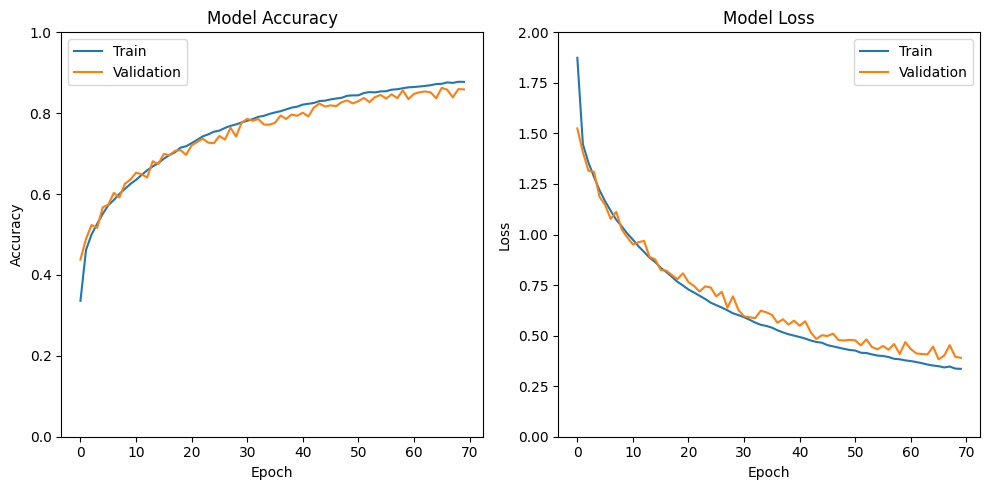

In [33]:
# Plotting model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.ylim(0, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.ylim(0, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)

**Validation with Pronation Data**

In [39]:
x_pronation, y_pronation = get_input(persons, gestures, "Pronation")
x_pronation = np.array(x_pronation)
y_pronation = np.array(y_pronation)

In [40]:
pronation_results = model.evaluate(x_pronation, y_pronation, batch_size=32)
print(pronation_results)

1238/1238 [==============================] - 2s 2ms/step - loss: 1.6544 - accuracy: 0.6119
[1.6544400453567505, 0.6119444370269775]


**Validation with Supination Data**

In [42]:
x_supination, y_supination = get_input(persons, gestures, "Supination")
x_supination = np.array(x_supination)
y_supination = np.array(y_supination)

In [43]:
supination_results = model.evaluate(x_supination, y_supination, batch_size=32)
print(supination_results)

1238/1238 [==============================] - 2s 2ms/step - loss: 1.7978 - accuracy: 0.5893
[1.797780990600586, 0.5893181562423706]
